In [88]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
data_path = r"d:\Downloads\archive (7)\online_retail_listing.csv"
data = pd.read_csv(data_path, sep=';', encoding='ISO-8859-1', on_bad_lines='warn')




In [89]:
num_rows = data.shape[0]
print(f"Number of rows: {num_rows}")


Number of rows: 1048575


In [90]:
print("Before conversion:\n", data.head())


Before conversion:
   Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

       InvoiceDate Price  Customer ID         Country  
0  1.12.2009 07:45  6,95      13085.0  United Kingdom  
1  1.12.2009 07:45  6,75      13085.0  United Kingdom  
2  1.12.2009 07:45  6,75      13085.0  United Kingdom  
3  1.12.2009 07:45   2,1      13085.0  United Kingdom  
4  1.12.2009 07:45  1,25      13085.0  United Kingdom  


In [91]:
if data['Customer ID'].isnull().any():
    data = data.dropna(subset=['Customer ID']).astype({'Customer ID': int})

In [92]:
num_rows2 = data.shape[0]
print(f"Number of rows: {num_rows2}")

Number of rows: 811893


In [93]:
# Convert 'Quantity' and 'Price' to numeric, coercing errors to NaN
data['Quantity'] = pd.to_numeric(data['Quantity'], errors='coerce')
data['Price'] = pd.to_numeric(data['Price'], errors='coerce')

# Remove rows with NaN values in 'Quantity' or 'Price' after the conversion
data.dropna(subset=['Quantity', 'Price'], inplace=True)

# Now remove transactions with negative values in 'Quantity' and 'Price'
data = data[(data['Quantity'] > 0) & (data['Price'] > 0)]


In [94]:
print(f"Cleaned dataset shape: {data.shape}")

Cleaned dataset shape: (2830, 8)


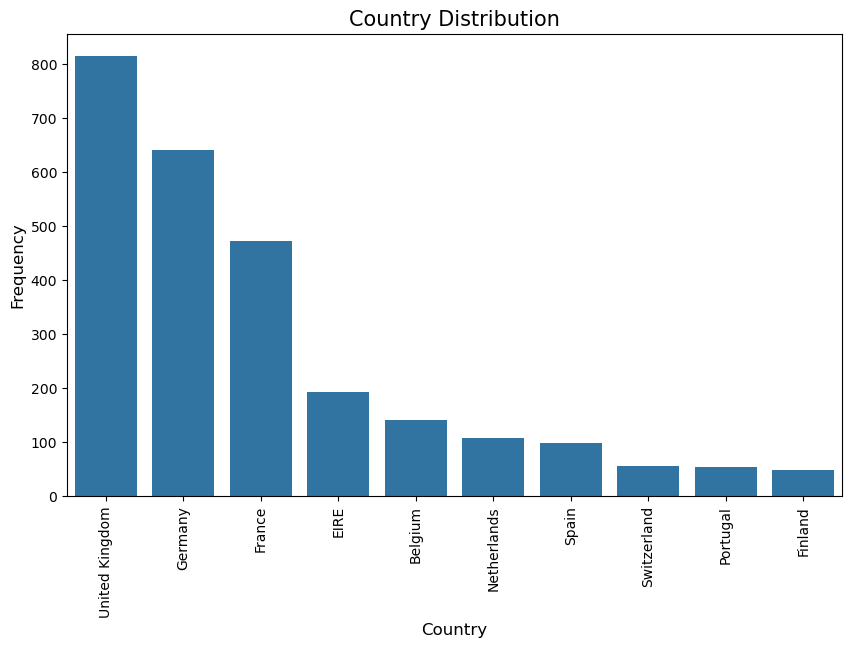

In [95]:
#visualize top 10 countries and using barplot cuz its catagorical data (groups)
country_counts = data['Country'].value_counts().head(10)  # Top 10 countries

# Barplot
plt.figure(figsize=(10, 6))
sns.barplot(x=country_counts.index, y=country_counts.values)

# Labels
plt.xlabel('Country', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Country Distribution', fontsize=15)
plt.xticks(rotation=90)
plt.show()

In [96]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2830 entries, 57 to 1048053
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Invoice      2830 non-null   object 
 1   StockCode    2830 non-null   object 
 2   Description  2830 non-null   object 
 3   Quantity     2830 non-null   int64  
 4   InvoiceDate  2830 non-null   object 
 5   Price        2830 non-null   float64
 6   Customer ID  2830 non-null   int32  
 7   Country      2830 non-null   object 
dtypes: float64(1), int32(1), int64(1), object(5)
memory usage: 187.9+ KB


In [97]:
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'], errors='coerce')

In [98]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2830 entries, 57 to 1048053
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Invoice      2830 non-null   object        
 1   StockCode    2830 non-null   object        
 2   Description  2830 non-null   object        
 3   Quantity     2830 non-null   int64         
 4   InvoiceDate  1172 non-null   datetime64[ns]
 5   Price        2830 non-null   float64       
 6   Customer ID  2830 non-null   int32         
 7   Country      2830 non-null   object        
dtypes: datetime64[ns](1), float64(1), int32(1), int64(1), object(4)
memory usage: 187.9+ KB


In [99]:
invalid_dates = data[data['InvoiceDate'].isna()]
print(f"Number of rows with invalid dates: {len(invalid_dates)}")

Number of rows with invalid dates: 1658


In [100]:
#delete invalid dates
data.dropna(subset=['InvoiceDate'], inplace=True)
print(data.shape)

(1172, 8)


In [101]:
data.nunique()

Invoice        1023
StockCode       111
Description     113
Quantity         56
InvoiceDate    1019
Price            50
Customer ID     449
Country          24
dtype: int64

In [102]:
data["Total"]=data["Price"]*data["Quantity"]

data.drop(columns=['StockCode', 'Description'], inplace=True)

data.head()

,Invoice,Quantity,InvoiceDate,Price,Customer ID,Country,Total
57,489438,30,2009-01-12 09:24:00,2.0,18102,United Kingdom,60.0
61,489438,56,2009-01-12 09:24:00,3.0,18102,United Kingdom,168.0
62,489438,56,2009-01-12 09:24:00,3.0,18102,United Kingdom,168.0
89,489439,3,2009-01-12 09:28:00,18.0,12682,France,54.0
126,489444,1,2009-01-12 09:55:00,141.0,12636,USA,141.0


In [103]:
from datetime import datetime
present_time = datetime.now()
rfm = data.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (present_time - x.max()).days,  # Recency
    'Invoice': 'count',                                      # Frequency
    'Total': 'mean'                                           # Average Price
}).rename(columns={'InvoiceDate': 'Recency', 
                   'Invoice': 'Frequency', 
                   'Total':"Monetary" 
                   })
rfm.head()

,Recency,Frequency,Monetary
Customer ID,,,
12348,4973,1,40.0
12350,5064,1,40.0
12352,5027,2,60.0
12356,5147,2,218.0
12357,4935,1,25.0


In [104]:
from datetime import datetime
present = datetime.now()
rfm= data.groupby('Customer ID').agg({
    'InvoiceDate' : lambda date : (present- date.max()).days,
    'Invoice' : lambda num : len(num),
    'Total' : lambda price : price.sum()}).rename(columns={'InvoiceDate': 'Recency', 
                   'Invoice': 'Frequency',
                   'Total':"Monetary" 
                   })
rfm.head()

,Recency,Frequency,Monetary
Customer ID,,,
12348,4973,1,40.0
12350,5064,1,40.0
12352,5027,2,120.0
12356,5147,2,436.0
12357,4935,1,25.0


In [105]:
rfm.info()

<class 'pandas.core.frame.DataFrame'>
Index: 449 entries, 12348 to 18284
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Recency    449 non-null    int64  
 1   Frequency  449 non-null    int64  
 2   Monetary   449 non-null    float64
dtypes: float64(1), int64(2)
memory usage: 12.3 KB


In [ ]:
rfm['Frequency'].nunique()

21

In [ ]:
print(rfm[rfm['RFM_Score']=='111'].sort_values('Monetary',ascending
=False).head())
print(rfm.columns)

             Recency  Frequency   Monetary  Recency_score  Frequency_score  \
Customer ID                                                                  
12626           4936          2  99.000000              1                1   
12480           4782          4  99.000000              1                1   
17380           5452          1  96.000000              1                1   
12394           4906          2  96.000000              1                1   
15521           4973          3  91.666667              1                1   

             Monetary_score RFM_Score  
Customer ID                            
12626                     1       111  
12480                     1       111  
17380                     1       111  
12394                     1       111  
15521                     1       111  
Index(['Recency', 'Frequency', 'Monetary', 'Recency_score', 'Frequency_score',
       'Monetary_score', 'RFM_Score'],
      dtype='object')


In [108]:
# Convert 'InvoiceDate' to datetime, specifying dayfirst=True
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'], dayfirst=True, errors='coerce')

# Check for any parsing issues (e.g., rows where InvoiceDate is NaT due to invalid format)
invalid_dates = data[data['InvoiceDate'].isna()]
print(f"Number of rows with invalid dates: {len(invalid_dates)}")

# Optionally, remove rows with invalid dates
data.dropna(subset=['InvoiceDate'], inplace=True)

# Create a snapshot date (latest date in the dataset)
snapshot_date = data['InvoiceDate'].max() + pd.DateOffset(days=1)

# Calculate RFM metrics
rfm = data.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,  # Recency
    'Invoice': 'count',                                      # Frequency
    'Quantity': 'sum',                                        # Total Quantity
    'Price': 'mean'                                           # Average Price
}).rename(columns={'InvoiceDate': 'Recency', 
                   'Invoice': 'Frequency', 
                   'Quantity': 'MonetaryValue'})

# Calculate Monetary Value as Quantity * Average Price
rfm['MonetaryValue'] = rfm['MonetaryValue'] * (data.groupby('Customer ID')['Price'].mean())

# Display the first few rows of the RFM DataFrame
rfm.head()

Number of rows with invalid dates: 0


,Recency,Frequency,MonetaryValue,Price
Customer ID,,,,
12348,221,1,40.0,40.0
12350,312,1,40.0,40.0
12352,275,2,120.0,40.0
12356,395,2,506.0,23.0
12357,183,1,25.0,25.0


In [110]:
# Create categories based on the distribution (specifying custom limits)
def categorize_recency(recency):
    if recency <= 30:
        return 5  # Very recent
    elif recency <= 90:
        return 4
    elif recency <= 180:
        return 3
    elif recency <= 365:
        return 2
    else:
        return 1  # Long time ago

def categorize_frequency(frequency):
    if frequency >= 50:
        return 5  # Frequent purchases
    elif frequency >= 20:
        return 4
    elif frequency >= 10:
        return 3
    elif frequency >= 5:
        return 2
    else:
        return 1  # Few purchases

def categorize_monetary(monetary):
    if monetary >= 1000:
        return 5  # High spenders
    elif monetary >= 500:
        return 4
    elif monetary >= 200:
        return 3
    elif monetary >= 100:
        return 2
    else:
        return 1  # Low spenders

# Apply the functions to the corresponding columns
rfm['Recency_score'] = rfm['Recency'].apply(categorize_recency)
rfm['Frequency_score'] = rfm['Frequency'].apply(categorize_frequency)
rfm['Monetary_score'] = rfm['MonetaryValue'].apply(categorize_monetary)

# Create a combined score
rfm['RFM_Score'] = rfm['Recency_score'].map(str) + rfm['Frequency_score'].map(str) + rfm['Monetary_score'].map(str)

# Define Customer Segments
def segment_customers(row):
    # Define the categories based on new rules
    if row['Recency_score'] >= 4 and row['Frequency_score'] >= 4 and row['Monetary_score'] >= 4:
        return 'Top Clients'
    elif row['Recency_score'] >= 3 and row['Frequency_score'] >= 3 and row['Monetary_score'] >= 3:
        return 'Loyal Spenders'
    elif row['Recency_score'] <= 2 and row['Frequency_score'] <= 2 and row['Monetary_score'] <= 2:
        return 'Low Activity'
    else:
        return 'Potential'

# Apply the function to segment customers
rfm['CustomerSegment'] = rfm.apply(segment_customers, axis=1)

# Count the number of customers in each segment
segment_counts = rfm['CustomerSegment'].value_counts()

C:\Users\Maram allah\AppData\Local\Temp\ipykernel_14832\4087471444.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=segment_counts.index, y=segment_counts.values, palette='Set2')


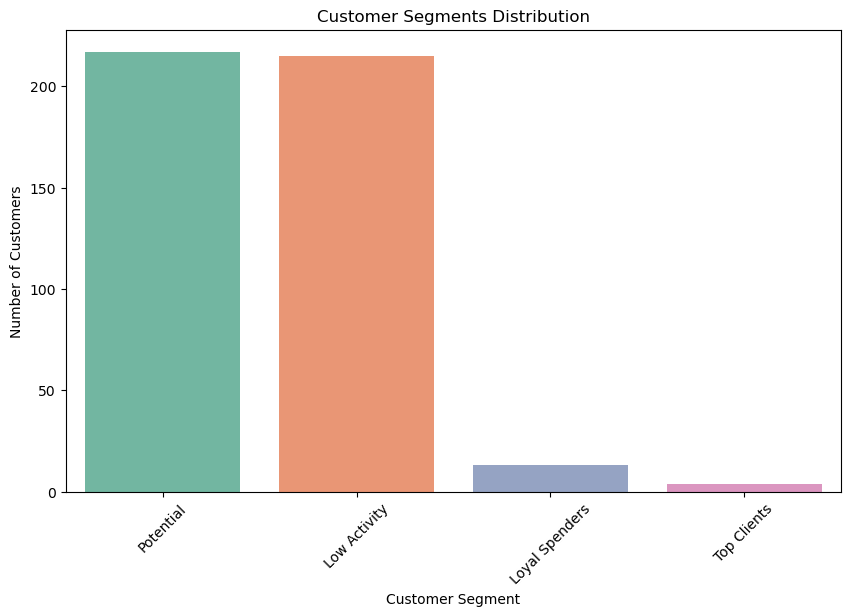

In [111]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x=segment_counts.index, y=segment_counts.values, palette='Set2')
plt.title('Customer Segments Distribution')
plt.xlabel('Customer Segment')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.show()

C:\Users\Maram allah\AppData\Local\Temp\ipykernel_14832\2986319590.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=rfm, x='CustomerSegment', y='Recency', palette='Set2')


([0, 1, 2, 3],
 [Text(0, 0, 'Low Activity'),
  Text(1, 0, 'Potential'),
  Text(2, 0, 'Loyal Spenders'),
  Text(3, 0, 'Top Clients')])

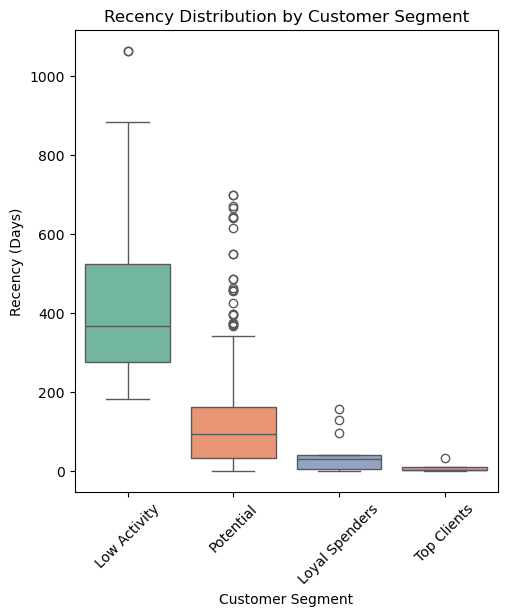

In [112]:
plt.figure(figsize=(12, 6))

# Boxplot for Recency
plt.subplot(1, 2, 1)
sns.boxplot(data=rfm, x='CustomerSegment', y='Recency', palette='Set2')
plt.title('Recency Distribution by Customer Segment')
plt.xlabel('Customer Segment')
plt.ylabel('Recency (Days)')
plt.xticks(rotation=45)